# **SpaceX Falcon 9 First Stage Landing Anslysis**

text here

 ## Phase I: Data Collection

### 1.1 Web scraping Falcon 9 and Falcon Heavy Launches Records from Wikipedia

In [158]:
# installing packages required fir web scrapping 
!pip3 install beautifulsoup4
!pip3 install requests
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

In [159]:
#importing 
import sys
import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd
import numpy as np
import datetime

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import seaborn as sns
import dash
from dash import html
from dash import dcc
from dash.dependencies import Input, Output
import plotly.express as px

#ML
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [160]:
# defining a helpful functions for HTML tables
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name    


In [163]:
# fixing url
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

#performing an HTTP GET method to request the Falcon9 Launch HTML page, as an HTTP response
#ad headers to avoid Wikipedia's blocks
headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/120.0.0.0 Safari/537.36"
    ),
    "Accept-Language": "en-US,en;q=0.9",
}

response = requests.get(url, headers=headers)

# creating a BeautifulSoup object from a response text content
soup = BeautifulSoup(response.text, "html.parser")

In [164]:
soup.title

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>

In [165]:
#aasigning all the HTML tables
html_tables = soup.find_all('table')

#taking 3d table and checking content
first_launch_table = html_tables[2]
#looks good
print(first_launch_table)

<table class="wikitable plainrowheaders collapsible" style="width: 100%;">
<tbody><tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11"><span class="cite-bracket">[</span>b<span class="cite-bracket">]</span></a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12"><span class="cite-bracket">[</span>c<span class="cite-bracket">]</span></a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 

In [166]:
column_names = []

#finding all "th" element on first_launch_table
cell = first_launch_table.find_all('th')

#getting a column name
for col in cell:
    names = extract_column_from_header(col)
    if names is not None and len(names) > 0:
        column_names.append(names)

#checking exctracted columns 
print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


In [167]:
#creating dictionary for keys to create a df later 

launch_dict= dict.fromkeys(column_names)

# removing an irrelvant column
del launch_dict['Date and time ( )']

# making a launch_dict to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []

# adding some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

In [168]:
extracted_row = 0

for table_number, table in enumerate(soup.find_all('table', class_="wikitable plainrowheaders collapsible")):
    for rows in table.find_all("tr"):
        if rows.th and rows.th.string:
            flight_number = rows.th.string.strip()
            flag = flight_number.isdigit()
        else:
            flag = False
        
        row = rows.find_all('td')

        if flag:
            extracted_row += 1
            launch_dict['Flight No.'].append(flight_number)

            # Date & Time
            datatimelist = date_time(row[0])
            date = datatimelist[0].strip(',') if datatimelist else ''
            time = datatimelist[1] if len(datatimelist) > 1 else ''
            launch_dict['Date'].append(date)
            launch_dict['Time'].append(time)

            # Booster version
            bv = booster_version(row[1])
            if not bv:
                bv = row[1].a.string.strip() if row[1].a else row[1].get_text(strip=True)
            launch_dict['Version Booster'].append(bv)

            # Launch site
            launch_site = row[2].a.string.strip() if row[2].a else row[2].get_text(strip=True)
            launch_dict['Launch site'].append(launch_site)

            # Payload
            payload = row[3].a.string.strip() if row[3].a else row[3].get_text(strip=True)
            launch_dict['Payload'].append(payload)

            # Payload mass
            payload_mass = get_mass(row[4])
            launch_dict['Payload mass'].append(payload_mass)

            # Orbit
            orbit = row[5].a.string.strip() if row[5].a else row[5].get_text(strip=True)
            launch_dict['Orbit'].append(orbit)

            # Customer
            customer = row[6].a.string.strip() if row[6].a and row[6].a.string else row[6].get_text(strip=True)
            launch_dict['Customer'].append(customer)

            # Launch outcome
            launch_outcome = next(row[7].strings, '').strip()
            launch_dict['Launch outcome'].append(launch_outcome)

            # Booster landing
            booster_landing = landing_status(row[8])
            launch_dict['Booster landing'].append(booster_landing)
            

In [169]:
#creating dataset
df_scrapped= pd.DataFrame({ key:pd.Series(value) for key, value in launch_dict.items() })
df_scrapped
#df.to_csv('spacex_web_scraped.csv', index=False)

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,F9 v1.07B0003.18,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.07B0004.18,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.07B0005.18,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success,F9 v1.07B0006.18,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success,F9 v1.07B0007.18,No attempt\n,1 March 2013,15:10
...,...,...,...,...,...,...,...,...,...,...,...
116,117,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success,F9 B5B1051.10657,Success,9 May 2021,06:42
117,118,KSC,Starlink,"~14,000 kg",LEO,SpaceX,Success,F9 B5B1058.8660,Success,15 May 2021,22:56
118,119,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success,F9 B5B1063.2665,Success,26 May 2021,18:59
119,120,KSC,SpaceX CRS-22,"3,328 kg",LEO,NASA,Success,F9 B5B1067.1668,Success,3 June 2021,17:29


### 1.2 API Data Collection

In [170]:
# takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

#the same for launchpad column
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

#and payload
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

# now get cores 
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

In [171]:
# defining spaceX url
spacex_url="https://api.spacexdata.com/v4/launches/past"

response = requests.get(spacex_url)

#checking - good
print(response.content)

b'[{"fairings":{"reused":false,"recovery_attempt":false,"recovered":false,"ships":[]},"links":{"patch":{"small":"https://images2.imgbox.com/94/f2/NN6Ph45r_o.png","large":"https://images2.imgbox.com/5b/02/QcxHUb5V_o.png"},"reddit":{"campaign":null,"launch":null,"media":null,"recovery":null},"flickr":{"small":[],"original":[]},"presskit":null,"webcast":"https://www.youtube.com/watch?v=0a_00nJ_Y88","youtube_id":"0a_00nJ_Y88","article":"https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html","wikipedia":"https://en.wikipedia.org/wiki/DemoSat"},"static_fire_date_utc":"2006-03-17T00:00:00.000Z","static_fire_date_unix":1142553600,"net":false,"window":0,"rocket":"5e9d0d95eda69955f709d1eb","success":false,"failures":[{"time":33,"altitude":null,"reason":"merlin engine failure"}],"details":"Engine failure at 33 seconds and loss of vehicle","crew":[],"ships":[],"capsules":[],"payloads":["5eb0e4b5b6c3bb0006eeb1e1"],"launchpad":"5e9e4502f5090995de566f86","flight_number":1,"name

In [172]:
#to make the requested JSON results more consistent, we will use the following static response object for this project
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'

response1 = requests.get(static_json_url)

#transgering to df
data_api = pd.json_normalize(response1.json())

#checking - good
data_api['static_fire_date_utc'].head(5)

0    2006-03-17T00:00:00.000Z
1                        None
2                        None
3    2008-09-20T00:00:00.000Z
4                        None
Name: static_fire_date_utc, dtype: object

In [173]:
#again using the API to get information about the launches using the IDs given for each launch.

#subset of our dataframe keeping only several features
data_api = data_api[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

#removing rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket
data_api = data_api[data_api['cores'].map(len)==1]
data_api = data_api[data_api['payloads'].map(len)==1]

# since payloads and cores are lists of size 1  - also extract the single value in the list and replace the feature
data_api['cores'] = data_api['cores'].map(lambda x : x[0])
data_api['payloads'] = data_api['payloads'].map(lambda x : x[0])

# converting the date_utc to a datetime datatype
data_api['date'] = pd.to_datetime(data_api['date_utc']).dt.date

# restricting the dates of the launches
data_api = data_api[data_api['date'] <= datetime.date(2020, 11, 13)]

data_api.head(5)

,rocket,payloads,launchpad,cores,flight_number,date_utc,date
0,5e9d0d95eda69955f709d1eb,5eb0e4b5b6c3bb0006eeb1e1,5e9e4502f5090995de566f86,"{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",1,2006-03-24T22:30:00.000Z,2006-03-24
1,5e9d0d95eda69955f709d1eb,5eb0e4b6b6c3bb0006eeb1e2,5e9e4502f5090995de566f86,"{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",2,2007-03-21T01:10:00.000Z,2007-03-21
3,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e5,5e9e4502f5090995de566f86,"{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",4,2008-09-28T23:15:00.000Z,2008-09-28
4,5e9d0d95eda69955f709d1eb,5eb0e4b7b6c3bb0006eeb1e6,5e9e4502f5090995de566f86,"{'core': '5e9e289ef359184f103b2627', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",5,2009-07-13T03:35:00.000Z,2009-07-13
5,5e9d0d95eda69973a809d1ec,5eb0e4b7b6c3bb0006eeb1e7,5e9e4501f509094ba4566f84,"{'core': '5e9e289ef359185f2b3b2628', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",6,2010-06-04T18:45:00.000Z,2010-06-04


In [174]:
#global variables - for the df
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [175]:
# learn the booster name for rocket
getBoosterVersion(data_api)

# learn the name of the launch site being used, the longitude, and the latitude.
getLaunchSite(data_api)

# learn the mass of the payload and the orbit that it is going to
getPayloadData(data_api)

# learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.
getCoreData(data_api)

In [176]:
#convert to dictionary
launch_dict = {'FlightNumber': list(data_api['flight_number']),
'Date': list(data_api['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

#new df
launch_df = pd.DataFrame(data=launch_dict)


In [177]:
#filter df to include only Falcon 9
launch_df_fl9 = launch_df[launch_df['BoosterVersion'] != 'Falcon 1']

#resetting numbers
launch_df_fl9.loc[:,'FlightNumber'] = list(range(1, launch_df_fl9.shape[0]+1))

In [178]:
#checking missing values
launch_df_fl9.isnull().sum() # some variables have missing values

# calculate the mean value of PayloadMass column
mean_payload = launch_df_fl9['PayloadMass'].mean()

# replace the np.nan values with its mean value
launch_df_fl9['PayloadMass'] = launch_df_fl9['PayloadMass'].replace(np.nan, mean_payload)

#checking again
launch_df_fl9.isnull().sum()

#saving df
#data_falcon9.to_csv('dataset_part_1.csv', index=False)

/var/folders/sw/pfdm_6f11l34m4hpcklg8qx80000gn/T/ipykernel_38697/3969473185.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [179]:
launch_df_fl9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.000000,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,87,2020-10-06,Falcon 9,15600.000000,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,88,2020-10-18,Falcon 9,15600.000000,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,89,2020-10-24,Falcon 9,15600.000000,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


## Phase II. Data wrangling

In [180]:
#calculating percentage of missing values
launch_df_fl9.isnull().sum()/len(df)*100

FlightNumber       0.000000
Date               0.000000
BoosterVersion     0.000000
PayloadMass        0.000000
Orbit              0.000000
LaunchSite         0.000000
Outcome            0.000000
Flights            0.000000
GridFins           0.000000
Reused             0.000000
Legs               0.000000
LandingPad        27.659574
Block              0.000000
ReusedCount        0.000000
Serial             0.000000
Longitude          0.000000
Latitude           0.000000
dtype: float64

In [181]:
#looking at the type
launch_df_fl9.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

In [182]:
#calculating launches on each site
launch_df_fl9['LaunchSite'].value_counts()

#orbits
launch_df_fl9['Orbit'].value_counts()

#outcomes
landing_outcomes = launch_df_fl9['Outcome'].value_counts()
landing_outcomes

Outcome
True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: count, dtype: int64

<code>True Ocean</code> means the mission outcome was successfully  landed to a specific region of the ocean while <code>False Ocean</code> means the mission outcome was unsuccessfully landed to a specific region of the ocean. <code>True RTLS</code> means the mission outcome was successfully  landed to a ground pad <code>False RTLS</code> means the mission outcome was unsuccessfully landed to a ground pad.<code>True ASDS</code> means the mission outcome was successfully  landed to a drone ship <code>False ASDS</code> means the mission outcome was unsuccessfully landed to a drone ship. <code>None ASDS</code> and <code>None None</code> these represent a failure to land.

In [183]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [184]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [188]:
#creating label for outcome column
# landing_class = 0 if bad_outcome
# landing_class = 1 otherwise
landing_class = [0 if outcome in bad_outcomes else 1 for outcome in launch_df_fl9['Outcome']]

launch_df_fl9 = data_falcon9
data_falcon9['Class']=landing_class
data_falcon9[['Class']].head(8)

data_falcon9["Class"].mean()
#data_falcon9.to_csv("dataset_part_2.csv", index=False)

data_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class,Year
4,1,2010-06-04,Falcon 9,5919.165341,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0,2010
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0,2012
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0,2013
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0,2013
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.000000,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058,1,2020
90,87,2020-10-06,Falcon 9,15600.000000,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058,1,2020
91,88,2020-10-18,Falcon 9,15600.000000,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058,1,2020
92,89,2020-10-24,Falcon 9,15600.000000,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857,1,2020


## Phase III. Exploratory Data Analysis

In [189]:
data_falcon9['LaunchSite'].unique()

array(['CCSFS SLC 40', 'VAFB SLC 4E', 'KSC LC 39A'], dtype=object)

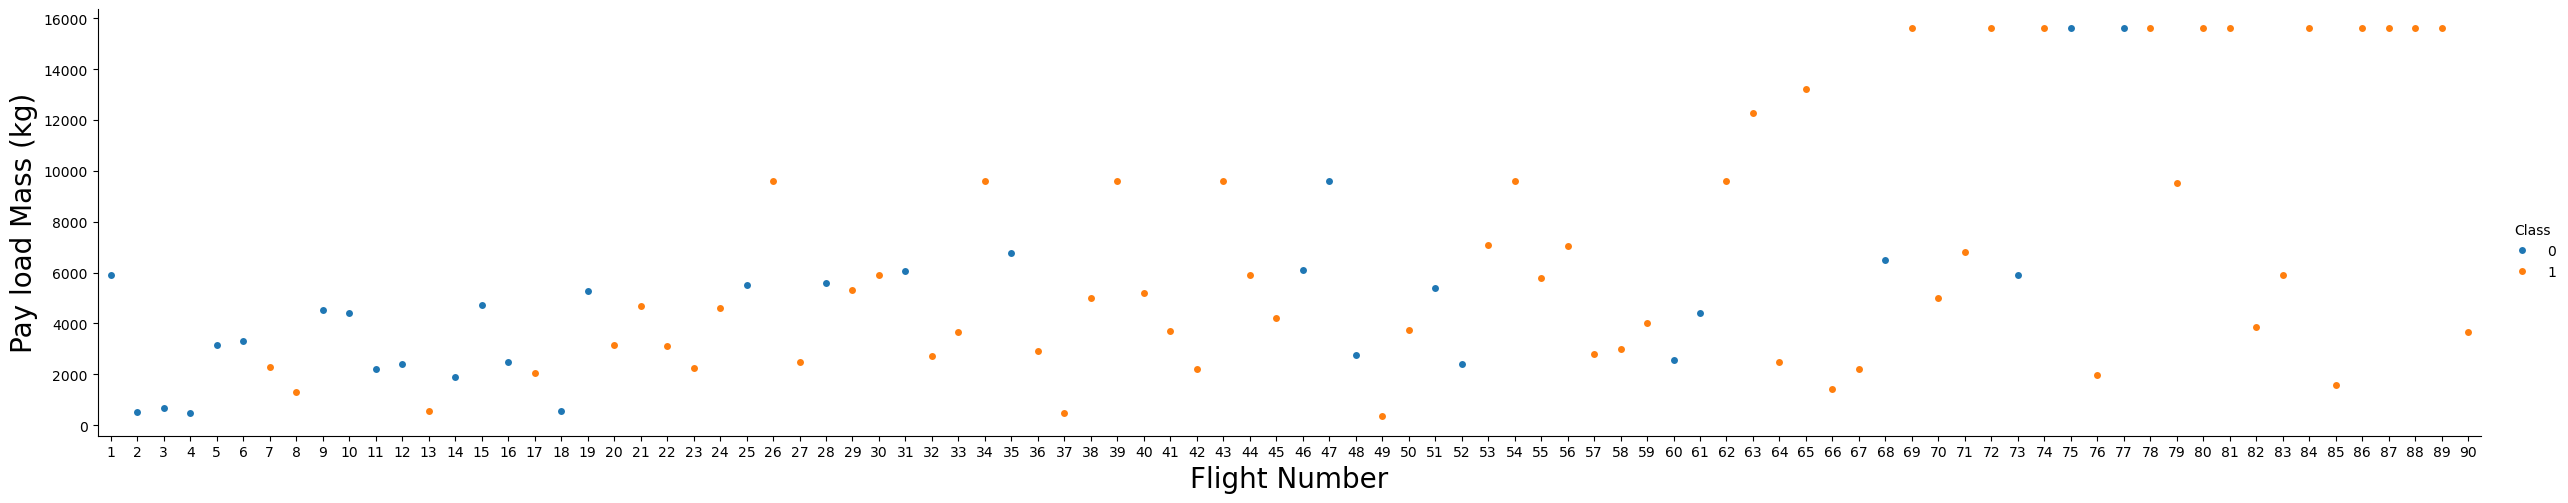

In [190]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=data_falcon9, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

Text(0.5, 1.0, 'Flight Number vs. Launch\xa0Site')

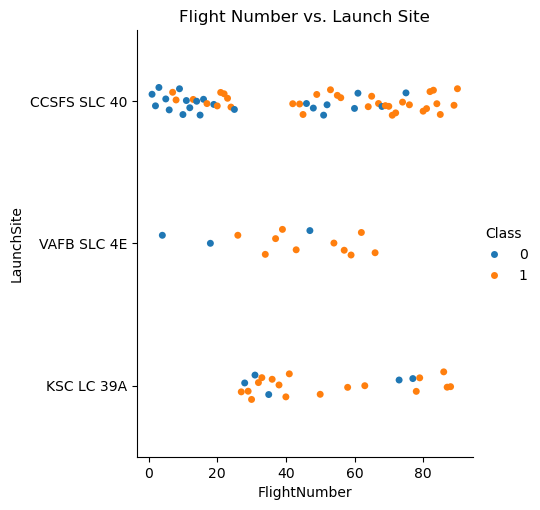

In [100]:
#relationship between Flight Number and Launch Site
sns.catplot(x= 'FlightNumber',
            y= 'LaunchSite',
            hue= 'Class',
            data =data_falcon9)
plt.title('Flight Number vs. Launch Site')

Text(0.5, 1.0, 'Payload vs. Launch Site')

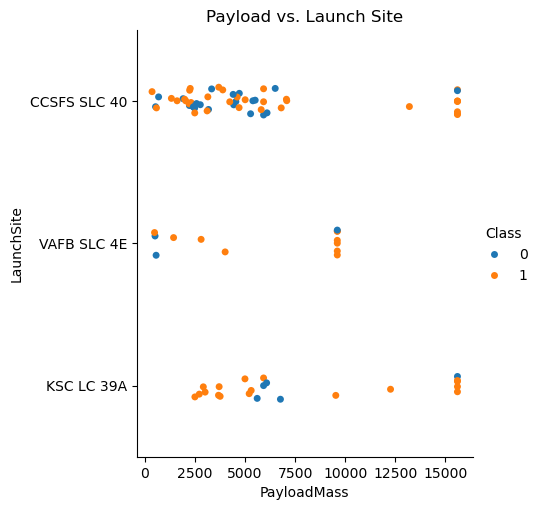

In [101]:
# relationship between Payload and Launch Site
sns.catplot(x='PayloadMass', 
            y= 'LaunchSite',
            hue ='Class',
            data =data_falcon9)
plt.title('Payload vs. Launch Site')

Text(0.5, 1.0, 'Success Rate vs. Orbit Type')

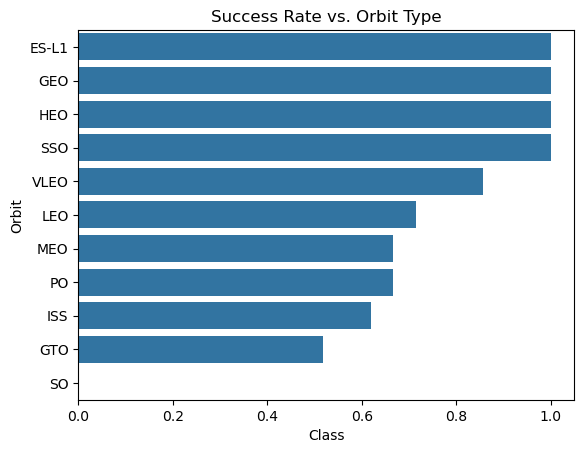

In [102]:
#relationship between success rate of each orbit type
# use groupby method on Orbit column and get the mean of Class column
or_suc = data_falcon9.groupby(['Orbit'])['Class'].mean().reset_index()
#sorting in descending order
or_suc = or_suc.sort_values(by='Class', ascending=False)

#plotting
sns.barplot(x= 'Class',
            y= 'Orbit',
            data =or_suc,
           orient = 'h')
plt.title('Success Rate vs. Orbit Type')

Text(0.5, 1.0, 'Flight Number vs. Orbit Type')

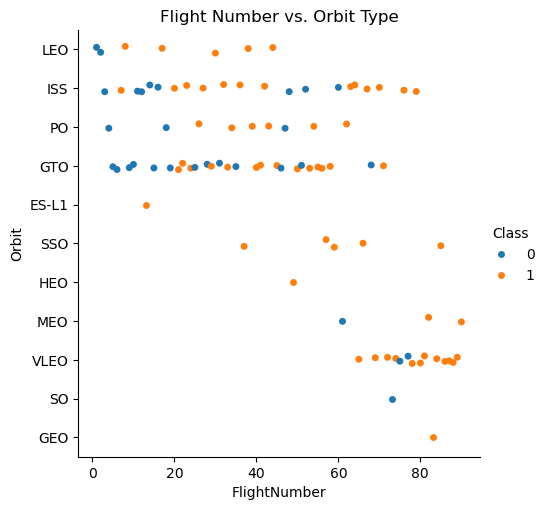

In [103]:
#relationship between FlightNumber and Orbit type\
sns.catplot(x= 'FlightNumber',
            y= 'Orbit',
            hue = 'Class',
           data=data_falcon9)
plt.title('Flight Number vs. Orbit Type')

Text(0.5, 1.0, 'Payload vs. Orbit\xa0Type')

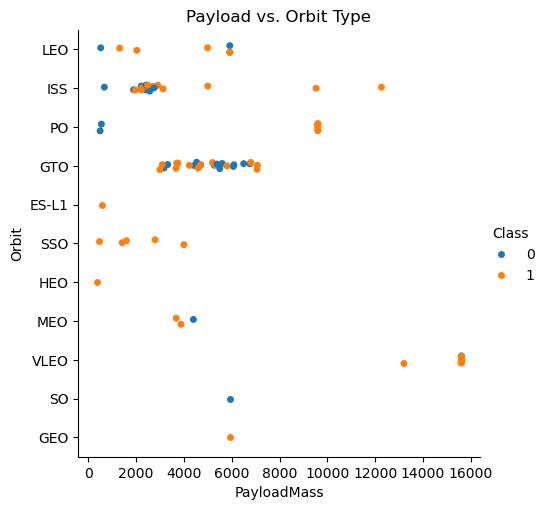

In [104]:
#relationship between Payload and Orbit type
sns.catplot(x='PayloadMass',
            y='Orbit',
            hue ='Class',
            data=data_falcon9)
plt.title('Payload vs. Orbit Type')

/var/folders/sw/pfdm_6f11l34m4hpcklg8qx80000gn/T/ipykernel_38697/2696520255.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['Date'] = pd.to_datetime(data_falcon9['Date'])
/var/folders/sw/pfdm_6f11l34m4hpcklg8qx80000gn/T/ipykernel_38697/2696520255.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['Year'] = data_falcon9['Date'].dt.year


Text(0.5, 1.0, 'Launch Success Yearly Trend')

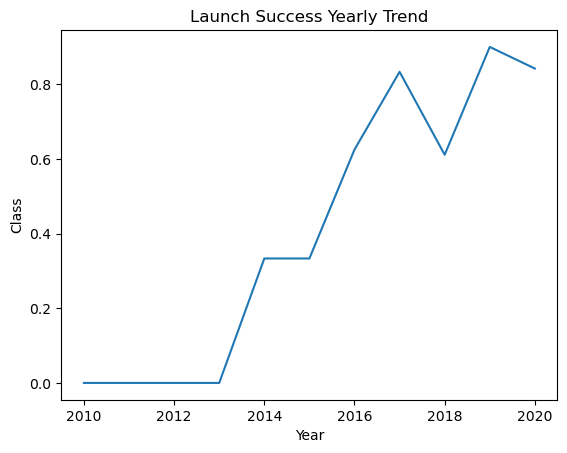

In [110]:
# the launch success yearly trend

#extracting year
data_falcon9['Date'] = pd.to_datetime(data_falcon9['Date'])
data_falcon9['Year'] = data_falcon9['Date'].dt.year

stat_year = data_falcon9.groupby(['Year'])['Class'].mean().reset_index()

sns.lineplot(x='Year',
            y= 'Class',
             data=stat_year)
plt.title('Launch Success Yearly Trend')

## IV. Data Visualization

### Dashboard with Dash

In [128]:
#loading data for dashboard 
spacex_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_dash.csv")

#translating class into float64
spacex_df['class'] = spacex_df['class'].astype('float64')
spacex_df.head()

#definning min and max payload 
max_payload = spacex_df['Payload Mass (kg)'].max()
min_payload = spacex_df['Payload Mass (kg)'].min()

In [132]:
# Create a dash application
app = dash.Dash(__name__)

# Create an app layout
app.layout = html.Div(children=[html.H1('SpaceX Launch Records Dashboard',
                                        style={'textAlign': 'center', 'color': '#503D36',
                                               'font-size': 40}),
                                # TASK 1: Add a dropdown list to enable Launch Site selection
                                # The default select value is for ALL sites
                                html.Div([
                                    html.Label('All Sites'),
                                dcc.Dropdown(id='site-dropdown',
                                              options=[{'label': 'All Sites', 'value': 'ALL'},
                                                       {'label': 'CCAFS SLC-40', 'value': 'CCAFS SLC-40'}, 
                                                       {'label': 'CCAFS LC-40', 'value': 'CCAFS LC-40'},
                                                       {'label': 'VAFB SLC-4E', 'value': 'VAFB SLC-4E'},
                                                       {'label': 'KSC LC-39A', 'value': 'KSC LC-39A'}
                                                      ],
                                             value='ALL',
                                             placeholder="Select a Site",
                                             searchable=True,
                                             style={'textAlign': 'center', 'width': '80%', 'font-size': 20, 'padding-left': 3}
                ) 
                                ]),
                                 html.Br(),

                                # TASK 2: Add a pie chart to show the total successful launches count for all sites
                                # If a specific launch site was selected, show the Success vs. Failed counts for the site
                                html.Div(dcc.Graph(id='success-pie-chart')),
                                html.Br(),

                                html.P("Payload range (Kg):"),
                                # TASK 3: Add a slider to select payload range
                                dcc.RangeSlider(id='payload-slider',min=0, 
                                                max=10000, step=1000, 
                                                marks={0: '0',
                                                       2500: '2500',
                                                      5000: '5000',
                                                      7500: '7500',
                                                      10000: '10000'},
                                                value=[min_payload, max_payload]),

                                # TASK 4: Add a scatter chart to show the correlation between payload and launch success
                                html.Div(dcc.Graph(id='success-payload-scatter-chart')),
                                ])

# TASK 2:
# Add a callback function for `site-dropdown` as input, `success-pie-chart` as output
# Function decorator to specify function input and output
# Add a callback function for `site-dropdown` as input, `success-pie-chart` as output
@app.callback(Output(component_id='success-pie-chart', component_property='figure'),
              Input(component_id='site-dropdown', component_property='value'))
def get_pie_chart(entered_site):
    filtered_df = spacex_df
    if entered_site == 'ALL':
        # For all sites, we calculate success vs. failure across the whole dataset
        fig = px.pie(filtered_df, values='class', 
                     names='Launch Site', 
                     title='Overall Launch Success vs Failure')
        return fig
    else:
        # Filter the data based on the selected launch site
        filtered_df = filtered_df[filtered_df['Launch Site'] == entered_site]
        
        # Group by 'Launch Site' and count the occurrences of each 'class' value (0 and 1)
        filtered_df1 = filtered_df.groupby('class').size().reset_index(name='count')
        
        # Create the pie chart using the grouped data
        fig = px.pie(filtered_df1, values='count', 
                     names='class', 
                     title=f'Launch Success vs Failure for {entered_site}')
        return fig

# TASK 4:
# Add a callback function for `site-dropdown` and `payload-slider` as inputs, `success-payload-scatter-chart` as output
@app.callback(Output(component_id='success-payload-scatter-chart', component_property='figure'),
              [Input(component_id='site-dropdown', component_property='value'), 
               Input(component_id="payload-slider", component_property="value")])
def get_scatter_chart(entered_site, payload_range):
    # Start with the full dataset
    filtered_df = spacex_df
    
    # Filter by Launch Site if needed
    if entered_site != 'ALL':
        filtered_df = filtered_df[filtered_df['Launch Site'] == entered_site]
    
    # Filter by Payload Mass (kg) range
    filtered_df = filtered_df[(filtered_df['Payload Mass (kg)'] >= payload_range[0]) & 
                               (filtered_df['Payload Mass (kg)'] <= payload_range[1])]

    # Create scatter plot
    fig = px.scatter(filtered_df,
                     x='Payload Mass (kg)',
                     y='class',
                     color='Booster Version Category',
                     title=f'Scatter Plot of Payload Mass vs. Launch Success for {entered_site}' if entered_site != 'ALL' else 'Scatter Plot of Payload Mass vs. Launch Success for All Sites')
    
    return fig

                               
# Run the app
if __name__ == '__main__':
    app.run(port=8051)


## Predictive Analysis

In [139]:
# creating function for confusion matrix
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

In [193]:
#selecting variables
features = data_falcon9[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]

# translating categories into dummies
X = pd.get_dummies(features,
                                  columns=['Orbit', 'LaunchSite', 'LandingPad','Serial'])
#converting all of them to float - it will be our X
X = features_one_hot.astype('float64')
X

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
4,1.0,5919.165341,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86.0,15600.000000,2.0,1.0,1.0,1.0,5.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
90,87.0,15600.000000,3.0,1.0,1.0,1.0,5.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
91,88.0,15600.000000,6.0,1.0,1.0,1.0,5.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [195]:
#creating a numpy array for class 
Y = data_falcon9['Class'].to_numpy()

In [196]:
# standardize data and reassign to X
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

In [198]:
#splitting data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
Y_test.shape

(18,)

In [200]:
#specify parameters
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],# l1 lasso l2 ridge
             'solver':['lbfgs']}

#create a logistic regression object 
lr=LogisticRegression()

#creating a GridSearchCV object
logreg_cv = GridSearchCV(estimator = lr,
                         param_grid = parameters,
                         cv= 10)
logreg_cv.fit(X_train, Y_train)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8214285714285714


In [201]:
#accuracy of the test data
accuracy = logreg_cv.score(X_test, Y_test)
print('Accuracy:', accuracy)

Accuracy: 0.8333333333333334


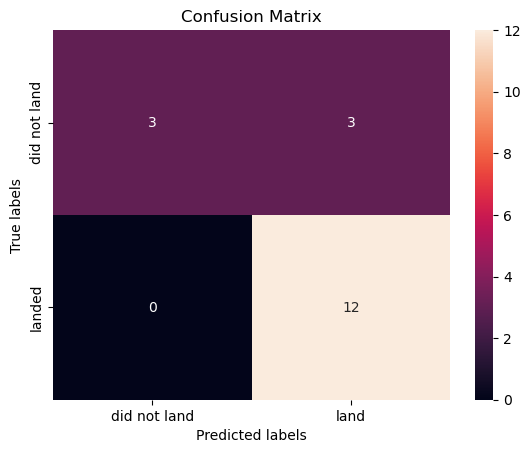

In [202]:
#let's look at confusion matrix 
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)
#3 false positive - it's the problem

In [203]:
#the same for svc 

#parameters
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
#svc object
svm = SVC()

#grid search
svm_cv = GridSearchCV(
    estimator = svm,
    param_grid = parameters,
    cv=10
)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
svm_cv.fit(X_train, Y_train)

#accuracy
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142858


In [204]:
#for test data
accuracy_svm = svm_cv.score(X_test, Y_test)
print('Accuracy:',accuracy_svm)

Accuracy: 0.8333333333333334


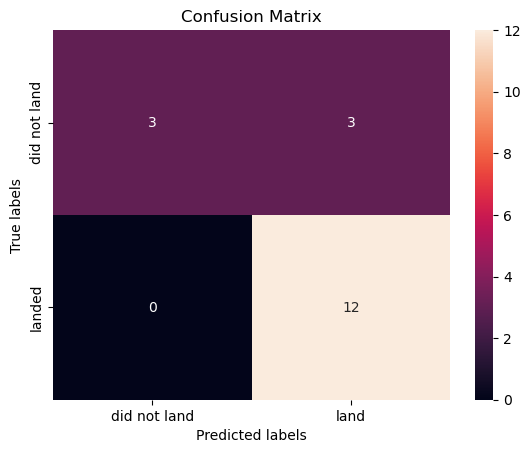

In [205]:
#confusion matrix
yhat_svm=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat_svm)

In [207]:
#and now for decision tree
#parameters
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

#object
tree = DecisionTreeClassifier()

#grid search
tree_cv = GridSearchCV(
    estimator = tree,
    param_grid = parameters,
    cv=10
)

tree_cv.fit(X_train, Y_train)

print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
accuracy : 0.8625


/opt/anaconda3/envs/Python_course/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:


3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/Python_course/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/Python_course/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/Python_course/lib/python3.12/site-packages/sklearn/base.py", line 436, in _validate_params


In [208]:
#accuracy for test data
print('Accuracy for DT model:' , tree_cv.score(X_test, Y_test))

Accuracy for DT model: 0.8333333333333334


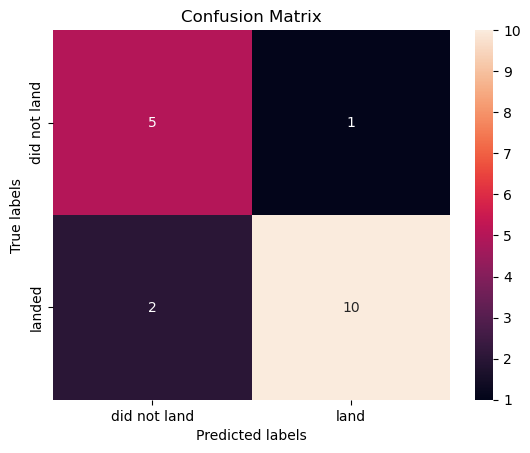

In [209]:
#confusion matrix 
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

In [210]:
# for KNN
#parameters
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

#object
KNN = KNeighborsClassifier()

#grid search
knn_cv = GridSearchCV(
    estimator = KNN,
    param_grid =parameters,
    cv=10
)

knn_cv.fit(X_train, Y_train)

#accuracy

print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
accuracy : 0.8339285714285714


In [211]:
#accuracy for test
print('KNN Accuracy:', knn_cv.score(X_test, Y_test))

KNN Accuracy: 0.7777777777777778


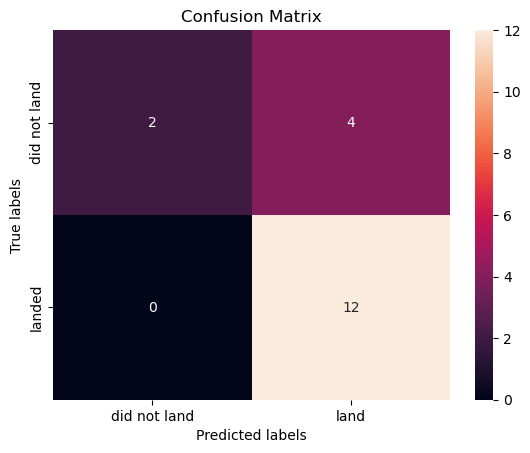

In [212]:
# confusion matrix
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

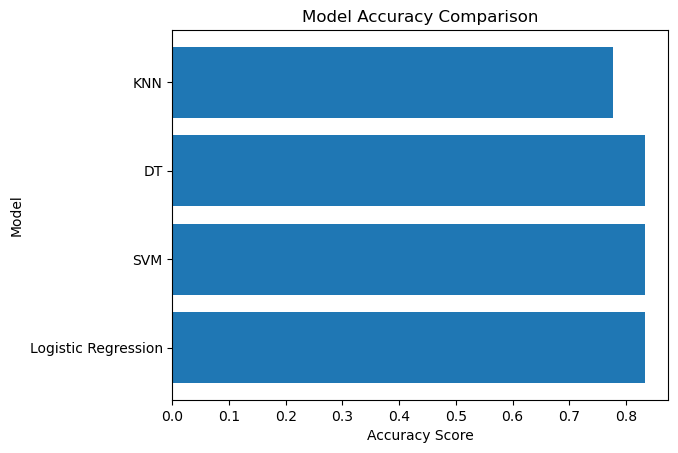

In [213]:
#finding the best method
accuracy_scores = [{
    'Logistic Regression' : logreg_cv.score(X_test, Y_test),
    'SVM' : svm_cv.score(X_test, Y_test),
    'DT' : tree_cv.score(X_test, Y_test),
    'KNN' : knn_cv.score(X_test, Y_test)
}]
accuracy_scores = pd.DataFrame(accuracy_scores).transpose()
accuracy_scores.columns = ['Score']
accuracy_scores.index.name = 'Model'  
accuracy_scores = accuracy_scores.sort_values(by = 'Score', ascending =False)


#a horizontal bar plot
plt.barh(accuracy_scores.index, accuracy_scores['Score'], label='Accuracy Score')

# adding labels and title
plt.xlabel('Accuracy Score')
plt.ylabel('Model')
plt.title('Model Accuracy Comparison')

# show
plt.show()
